In [171]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
# train test split
from sklearn.model_selection import train_test_split
# temperature prediction
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.metrics import r2_score


# 2 Prepare Data

In [172]:
# read data
train = pd.read_csv('./data/IOT_Train.csv')
data = train
train.head()

,mac,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,time,humid,light,pm10,pm2.5,rainfall,wind_direct,wind_speed,temp
0,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-07-20 15:00:00+07:00,70.6,59.0,NaN,NaN,0.0,45.0,4.3,32.6
1,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-05-16 09:00:00+07:00,62.3,76.0,NaN,NaN,0.0,45.0,1.9,37.9
2,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-06-26 19:00:00+07:00,90.3,0.0,NaN,NaN,0.0,135.0,3.2,26.4
3,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-07-16 04:00:00+07:00,91.7,0.0,NaN,NaN,0.0,157.5,0.0,25.6
4,3C71BF18EA64,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,2022-05-30 08:00:00+07:00,59.1,71.0,NaN,NaN,0.0,180.0,2.3,36.2


In [173]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13635 entries, 0 to 13634
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mac            13635 non-null  object 
 1   station_name   13635 non-null  object 
 2   tambon_code    13635 non-null  int64  
 3   tambon_namt    13635 non-null  object 
 4   amphur_code    13635 non-null  int64  
 5   amphur_namt    13635 non-null  object 
 6   province_code  13635 non-null  int64  
 7   province_namt  13635 non-null  object 
 8   latitude       13635 non-null  float64
 9   longitude      13635 non-null  float64
 10  time           13635 non-null  object 
 11  humid          13635 non-null  float64
 12  light          13635 non-null  float64
 13  pm10           6841 non-null   float64
 14  pm2.5          6841 non-null   float64
 15  rainfall       13635 non-null  float64
 16  wind_direct    13635 non-null  float64
 17  wind_speed     13635 non-null  float64
 18  temp  

In [174]:
# drop row that temp = na
train = train[train['temp'].notna()]
# encode time features change Dtype time from object --> datetime64
train['time'] = pd.to_datetime(train['time'])
# add day in year column
train['day_in_year'] = train['time'].dt.dayofyear
# time in day(hours) from datetime
train['time_in_day'] = train['time'].dt.hour
# drop unused columns
train.drop(['mac', 'time','pm10','pm2.5'], axis=1, inplace=True)
print(train.info())
# drop row that has missing values
print(train.isna().sum())
train.dropna(inplace=True)
print('--------------------------')
print(train.isna().sum())
train=train.reset_index(drop = True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13634 entries, 0 to 13634
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   station_name   13634 non-null  object 
 1   tambon_code    13634 non-null  int64  
 2   tambon_namt    13634 non-null  object 
 3   amphur_code    13634 non-null  int64  
 4   amphur_namt    13634 non-null  object 
 5   province_code  13634 non-null  int64  
 6   province_namt  13634 non-null  object 
 7   latitude       13634 non-null  float64
 8   longitude      13634 non-null  float64
 9   humid          13634 non-null  float64
 10  light          13634 non-null  float64
 11  rainfall       13634 non-null  float64
 12  wind_direct    13634 non-null  float64
 13  wind_speed     13634 non-null  float64
 14  temp           13634 non-null  float64
 15  day_in_year    13634 non-null  int64  
 16  time_in_day    13634 non-null  int64  
dtypes: float64(8), int64(5), object(4)
memory usage: 1

/var/folders/cy/8gk9k6q514gcdtsy9630wd1h0000gn/T/ipykernel_45616/3008954967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['time'] = pd.to_datetime(train['time'])
/var/folders/cy/8gk9k6q514gcdtsy9630wd1h0000gn/T/ipykernel_45616/3008954967.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['day_in_year'] = train['time'].dt.dayofyear
/var/folders/cy/8gk9k6q514gcdtsy9630wd1h0000gn/T/ipykernel_45616/3008954967.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [175]:
train.head()

,station_name,tambon_code,tambon_namt,amphur_code,amphur_namt,province_code,province_namt,latitude,longitude,humid,light,rainfall,wind_direct,wind_speed,temp,day_in_year,time_in_day
0,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,70.6,59.0,0.0,45.0,4.3,32.6,201,15
1,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,62.3,76.0,0.0,45.0,1.9,37.9,136,9
2,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,90.3,0.0,0.0,135.0,3.2,26.4,177,19
3,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,91.7,0.0,0.0,157.5,0.0,25.6,197,4
4,บ้านนา_2,300903,กำปัง,3009,โนนไทย,30,นครราชสีมา,15.112831,102.052114,59.1,71.0,0.0,180.0,2.3,36.2,150,8


In [176]:
# Cut out the outliers humid with sklearn
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(train[['humid', 'temp']])
X_scores = clf.negative_outlier_factor_
outlier_index = np.where(y_pred == -1)
outlier_index = outlier_index[0]
print('outliers size', outlier_index.shape[0])
print('From', train.shape[0], 'to', train.shape[0] - outlier_index.shape[0])
# drop outliers
train.drop(outlier_index, inplace=True)

outliers size 1364
From 13634 to 12270


In [177]:
# # Cut out the outliers humid with sklearn
# clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# y_pred = clf.fit_predict(train[['humid', 'temp']])
# X_scores = clf.negative_outlier_factor_
# outlier_index = np.where(y_pred == -1)
# outlier_index = outlier_index[0]
# print('outliers size', outlier_index.shape[0])
# print('From', train.shape[0], 'to', train.shape[0] - outlier_index.shape[0])
# # drop outliers
# train.drop(outlier_index, inplace=True)
# # plot scatter plot humidity per temperature
# plt.figure(figsize=(10, 10))
# plt.scatter(train['humid'], train['temp'], c=train['temp'], cmap='viridis')
# plt.xlabel('humidity')
# plt.ylabel('temperature')
# plt.title('humidity per temperature')
# plt.show()

In [178]:
# encode the categorical data to numerical data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['tambon_namt'] = le.fit_transform(train['tambon_namt'])
train['station_name'] = le.fit_transform(train['station_name'])
train['province_namt'] = le.fit_transform(train['province_namt'])
train['amphur_namt'] = le.fit_transform(train['amphur_namt'])

# simplify feature by dropping out some features
train.drop(['tambon_code', 'amphur_code', 'province_code', 'province_namt', 'station_name'], axis=1, inplace=True)
train.head(2)
train = train.reset_index(drop = True)

In [179]:
# split x , y
y = pd.DataFrame(train['temp'])
x = pd.DataFrame(train.drop(columns='temp'))
x=x.reset_index(drop = True)
y=y.reset_index(drop = True)
print(x)
print(y)

       tambon_namt  amphur_namt   latitude   longitude  humid  light  \
0                0            7  15.112831  102.052114   70.6   59.0   
1                0            7  15.112831  102.052114   62.3   76.0   
2                0            7  15.112831  102.052114   90.3    0.0   
3                0            7  15.112831  102.052114   91.7    0.0   
4                0            7  15.112831  102.052114   59.1   71.0   
...            ...          ...        ...         ...    ...    ...   
12265            6            5  16.494229  104.350891   64.8   89.0   
12266            6            5  16.494229  104.350891   97.9    0.0   
12267            6            5  16.494229  104.350891   87.9   37.0   
12268            6            5  16.494229  104.350891   89.9    0.0   
12269            6            5  16.494229  104.350891   66.3   43.0   

       rainfall  wind_direct  wind_speed  day_in_year  time_in_day  
0           0.0         45.0         4.3          201           15

In [180]:
# correlation
lower = pd.DataFrame(np.tril(x.corr(),-1),columns = x.corr().columns)
to_drop = [column for column in lower.columns if any(lower[column] > 0.8)]
x.drop(columns = to_drop,inplace=True)
to_drop

[]

In [181]:
x

,tambon_namt,amphur_namt,latitude,longitude,humid,light,rainfall,wind_direct,wind_speed,day_in_year,time_in_day
0,0,7,15.112831,102.052114,70.6,59.0,0.0,45.0,4.3,201,15
1,0,7,15.112831,102.052114,62.3,76.0,0.0,45.0,1.9,136,9
2,0,7,15.112831,102.052114,90.3,0.0,0.0,135.0,3.2,177,19
3,0,7,15.112831,102.052114,91.7,0.0,0.0,157.5,0.0,197,4
4,0,7,15.112831,102.052114,59.1,71.0,0.0,180.0,2.3,150,8
...,...,...,...,...,...,...,...,...,...,...,...
12265,6,5,16.494229,104.350891,64.8,89.0,0.0,135.0,0.8,146,11
12266,6,5,16.494229,104.350891,97.9,0.0,4.2,0.0,0.0,165,1
12267,6,5,16.494229,104.350891,87.9,37.0,0.0,45.0,3.0,139,6
12268,6,5,16.494229,104.350891,89.9,0.0,0.0,315.0,0.0,166,2


In [182]:
x.loc[[100]]

,tambon_namt,amphur_namt,latitude,longitude,humid,light,rainfall,wind_direct,wind_speed,day_in_year,time_in_day
100,0,7,15.112831,102.052114,90.2,0.0,0.0,157.5,0.0,199,5


In [183]:
# stadard_scaler data
standard_scaler = preprocessing.StandardScaler()
standard_x = pd.DataFrame(standard_scaler.fit_transform(x),columns= x.columns)
standard_x

,tambon_namt,amphur_namt,latitude,longitude,humid,light,rainfall,wind_direct,wind_speed,day_in_year,time_in_day
0,-1.506445,1.523281,-0.135521,0.172714,-0.836508,0.775415,-0.124399,-1.186554,-0.002570,1.311059,0.506472
1,-1.506445,1.523281,-0.135521,0.172714,-1.524786,1.271942,-0.124399,-1.186554,-0.015103,-1.207561,-0.355145
2,-1.506445,1.523281,-0.135521,0.172714,0.797116,-0.947827,-0.124399,-0.280368,-0.008314,0.381107,1.080883
3,-1.506445,1.523281,-0.135521,0.172714,0.913211,-0.947827,-0.124399,-0.053821,-0.025025,1.156067,-1.073159
4,-1.506445,1.523281,-0.135521,0.172714,-1.790146,1.125905,-0.124399,0.172726,-0.013014,-0.665089,-0.498748
...,...,...,...,...,...,...,...,...,...,...,...
12265,1.107254,0.657893,0.447177,1.228137,-1.317473,1.651640,-0.124399,-0.280368,-0.020847,-0.820081,-0.067939
12266,1.107254,0.657893,0.447177,1.228137,1.427346,-0.947827,3.681117,-1.639647,-0.025025,-0.083869,-1.503967
12267,1.107254,0.657893,0.447177,1.228137,0.598096,0.132850,-0.124399,-1.186554,-0.009359,-1.091317,-0.785953
12268,1.107254,0.657893,0.447177,1.228137,0.763946,-0.947827,-0.124399,1.532005,-0.025025,-0.045121,-1.360364


In [184]:
# spliet train and test data
X = standard_x
Y = y
seed = 62
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [185]:

# Create Model List
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR


regression = { 'LR': LinearRegression(), 'SVR': SVR(), }
regression = { 'LR': LinearRegression()}
# Create Parameter Dictionary for Linear Regression
fit_intercept = [True, False]
normalize = [True, False]
params_LR = dict( fit_intercept = fit_intercept, normalize = normalize)
#Create Parameter Dictionary for SVR
kernel = ['linear', 'rbf', 'poly']
C_list = [10, 100]
C_list = [100]
ep_list = [0.1, 1, 5]
ep_list = [0.1]
gamma = [0.01, 0.1]
gamma = [0.1]
degree = [2, 3]       #3x2x3x2x2 = 72
degree = [2]       #3x2x3x2x2 = 72
params_SVR = dict( kernel = kernel, C = C_list, epsilon = ep_list, gamma = gamma, degree = degree )

In [186]:
# comment take long time to train 
# for EST in regression:
#     model = regression[EST]
#     if (EST == 'LR'):
#         params = params_LR
#     else:
#         params = params_SVR

#     grid = GridSearchCV( 
#     estimator=model,                         #model
#     n_jobs = 8,                              #thread ที่ใช้               
#     verbose = 0,                             #ความละเอียดในการเปิด log
#     cv = 5,                                  #kfold
#     scoring = 'neg_mean_absolute_error',     #neg mean - mse
#     param_grid = params)                     #parameter ที่ใช้กับ model
#     grid_result = grid.fit(x_train, y_train)

# # Show Best Parameters for both models
# print('Best params: ',grid_result.best_params_)
# print('Best score: ', grid_result.best_score_)

In [187]:
model_svr = SVR(kernel = 'rbf', epsilon = 0.1, C = 100 )
model_svr.fit(x_train, y_train)
y_pred = model_svr.predict(x_test)
r2 = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
print('MAE : ',mae)
print('r2 : ',r2)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE :  0.6298941500876452
r2 :  0.9558311927560466


In [188]:
model_LM = LinearRegression(fit_intercept=True, n_jobs=4, normalize=False)
model_LM.fit(x_train, y_train)
y_pred = model_LM.predict(x_test)
r2 = r2_score(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
print('MAE : ',mae)
print('r2 : ',r2)

MAE :  0.9316524742770332
r2 :  0.9065351150239703


/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Feature: 0, Score: 0.03236
Feature: 1, Score: 0.00290
Feature: 2, Score: 0.16525
Feature: 3, Score: 0.31366
Feature: 4, Score: 22.42585
Feature: 5, Score: 0.97315
Feature: 6, Score: -0.00003
Feature: 7, Score: 0.00010
Feature: 8, Score: 0.00011
Feature: 9, Score: 0.22349
Feature: 10, Score: 0.05053


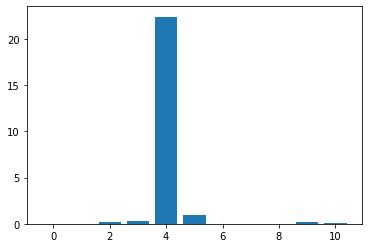

In [189]:
from sklearn.inspection import permutation_importance
# perform permutation importance
results = permutation_importance(model_LM, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [190]:
# import catboost
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor(iterations=3000, learning_rate=0.04, depth=9, loss_function='RMSE')
cat_model.fit(x_train, y_train)

0:	learn: 3.9885325	total: 14.9ms	remaining: 44.6s
1:	learn: 3.8539646	total: 23.8ms	remaining: 35.7s
2:	learn: 3.7247391	total: 32.8ms	remaining: 32.7s
3:	learn: 3.6013268	total: 45.6ms	remaining: 34.2s
4:	learn: 3.4818099	total: 59.2ms	remaining: 35.5s
5:	learn: 3.3661458	total: 63.4ms	remaining: 31.6s
6:	learn: 3.2508180	total: 68.7ms	remaining: 29.4s
7:	learn: 3.1448571	total: 71.5ms	remaining: 26.7s
8:	learn: 3.0449979	total: 75.1ms	remaining: 25s
9:	learn: 2.9466538	total: 79ms	remaining: 23.6s
10:	learn: 2.8522324	total: 81.9ms	remaining: 22.3s
11:	learn: 2.7619661	total: 84ms	remaining: 20.9s
12:	learn: 2.6730484	total: 86.6ms	remaining: 19.9s
13:	learn: 2.5920014	total: 89.4ms	remaining: 19.1s
14:	learn: 2.5119649	total: 93.2ms	remaining: 18.5s
15:	learn: 2.4381496	total: 96.2ms	remaining: 17.9s
16:	learn: 2.3635508	total: 99ms	remaining: 17.4s
17:	learn: 2.2928098	total: 103ms	remaining: 17s
18:	learn: 2.2237151	total: 105ms	remaining: 16.5s
19:	learn: 2.1588036	total: 108ms	

In [191]:
# eval catboost
y_pred = cat_model.predict(x_test)
print('R2: ', r2_score(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))


R2:  0.9802520257743784
MAE:  0.43789388782356786


In [192]:
# 0 - 12269
n = 8888
row=train.loc[[n]]
print(row)
t=row.temp
preT = X.loc[[n]]
print('---------------------------------------------------------------------')
print('ค่า temp ที่ ถูกต้องใน row ที่',t)
print('---------------------------------------------------------------------')
print('ค่า temp ที่ predict ได้ใน row ที่ ',n,cat_model.predict(preT))


      tambon_namt  amphur_namt  latitude  longitude  humid  light  rainfall  \
8888            7            6  16.71299  98.573417   69.8   81.0       0.0   

      wind_direct  wind_speed  temp  day_in_year  time_in_day  
8888        135.0         4.9  31.2          187           14  
---------------------------------------------------------------------
ค่า temp ที่ ถูกต้องใน row ที่ 8888    31.2
Name: temp, dtype: float64
---------------------------------------------------------------------
ค่า temp ที่ predict ได้ใน row ที่  8888 [31.01776354]


[ 3.51951871  2.92303359  4.08405721  6.25258418 52.45140431  5.47387385
  0.28698652  1.18636745  2.15859334 16.39351987  5.27006096]
Feature:  0 Score:  3.5195187128229652
Feature:  1 Score:  2.923033588149862
Feature:  2 Score:  4.084057209947239
Feature:  3 Score:  6.252584182364481
Feature:  4 Score:  52.45140431107055
Feature:  5 Score:  5.473873848398963
Feature:  6 Score:  0.2869865249033571
Feature:  7 Score:  1.1863674515882938
Feature:  8 Score:  2.158593335330655
Feature:  9 Score:  16.393519874808124
Feature:  10 Score:  5.270060960615513


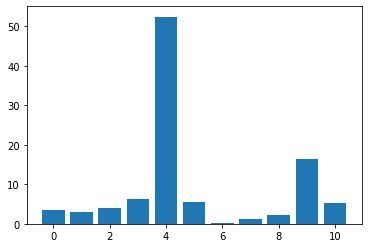

In [193]:
from matplotlib import pyplot
importance = cat_model.feature_importances_
print(importance)
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: ',i,'Score: ',v)
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# ทดลอง model

In [194]:
#Decission Tree regressor
from sklearn.tree import DecisionTreeRegressor #import model
model = DecisionTreeRegressor(max_depth=10, #tune parameter
                           min_samples_leaf=1,
                           random_state=123)
model.fit(x_train, y_train)
x_train = x_train.astype(np.float32)

#Predict y(test_data)
y_pred = model.predict(x_test)
# y_pred = cat_model.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))


MAE:  0.7062801703510839
R2:  0.9479103566557147


In [195]:
# Random Forest parameter
ASM_function = ['entropy','gini']
nEstimator = 100 
nJob = 8
rState =10
# Model Training 
from sklearn.ensemble import RandomForestRegressor
RandomF = RandomForestRegressor(n_estimators=nEstimator,n_jobs=nJob,random_state=rState)
RandomF.fit(x_train,y_train)
#Model Testing
y_pred = RandomF.predict(x_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

/var/folders/cy/8gk9k6q514gcdtsy9630wd1h0000gn/T/ipykernel_45616/2245312833.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RandomF.fit(x_train,y_train)


MAE:  0.5604800325998373
R2:  0.9677711565885347
